# 🎬 Netflix Dataset Analysis (2008 - 2019)

This project explores Netflix's catalog (2008 - 2019) to uncover trends in content growth, genres, ratings, and actors.  
Using **4,000+ titles**, we perform data cleaning, exploratory data analysis (EDA), and visualization to reveal insights about how Netflix has evolved over time.

## Set Up

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('netflix_titles_nov_2019.csv')

# Quick look at data
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5837 entries, 0 to 5836
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       5837 non-null   int64 
 1   title         5837 non-null   object
 2   director      3936 non-null   object
 3   cast          5281 non-null   object
 4   country       5410 non-null   object
 5   date_added    5195 non-null   object
 6   release_year  5837 non-null   int64 
 7   rating        5827 non-null   object
 8   duration      5837 non-null   object
 9   listed_in     5837 non-null   object
 10  description   5837 non-null   object
 11  type          5837 non-null   object
dtypes: int64(2), object(10)
memory usage: 547.3+ KB


### Descriptive summary of the dataset

In [2]:
df.describe()

,show_id,release_year
count,5.837000e+03,5837.000000
mean,7.730079e+07,2013.688539
std,9.479777e+06,8.419088
min,2.698800e+05,1925.000000
25%,8.004520e+07,2013.000000
50%,8.016353e+07,2016.000000
75%,8.024188e+07,2018.000000
max,8.122720e+07,2020.000000


### To check how many records and columns

In [3]:
df.shape

(5837, 12)

### List of all the column names

In [4]:
df.columns

Index(['show_id', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'type'],
      dtype='object')

# Data Cleaning

### Check for missing values

In [5]:
df.isnull().sum()

show_id            0
title              0
director        1901
cast             556
country          427
date_added       642
release_year       0
rating            10
duration           0
listed_in          0
description        0
type               0
dtype: int64

### Fill missing values for categorical columns

In [6]:
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Not Rated')
df['cast'] = df['cast'].fillna('Unknown')
df['director'] = df['director'].fillna('Unknown')

### Convert date_added to datetime

In [7]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

In [8]:
df.isnull().sum()

show_id           0
title             0
director          0
cast              0
country           0
date_added      642
release_year      0
rating            0
duration          0
listed_in         0
description       0
type              0
dtype: int64

### Check for duplicate rows

In [9]:
df.duplicated().sum()

0

## Time-Based Analysis

### Content Growth Over Time

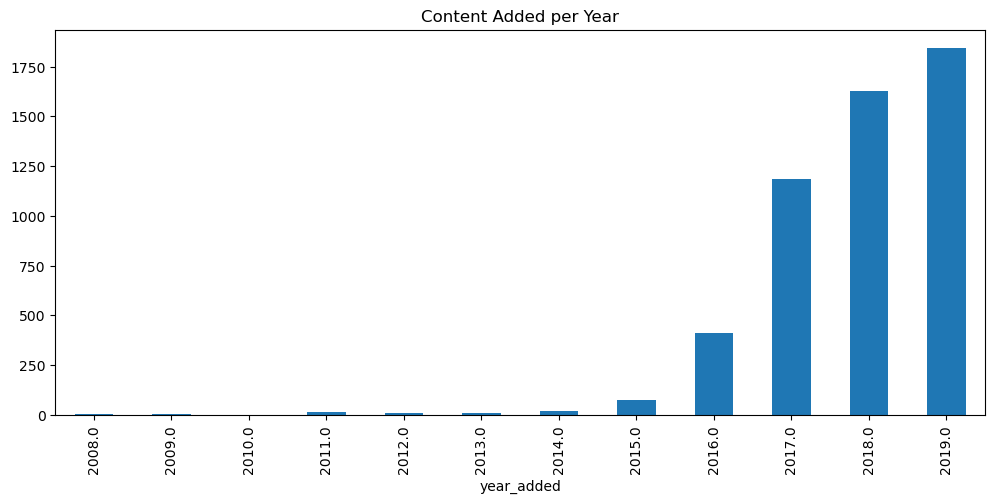

In [10]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Content added per year
year_count = df.groupby('year_added').size()
year_count.plot(kind='bar', figsize=(12,5), title='Content Added per Year')
plt.show()

**Observation:**
Netflix’s content library grew sharply after 2015, reflecting its global expansion and heavy investment in original programming.

### Content added per month

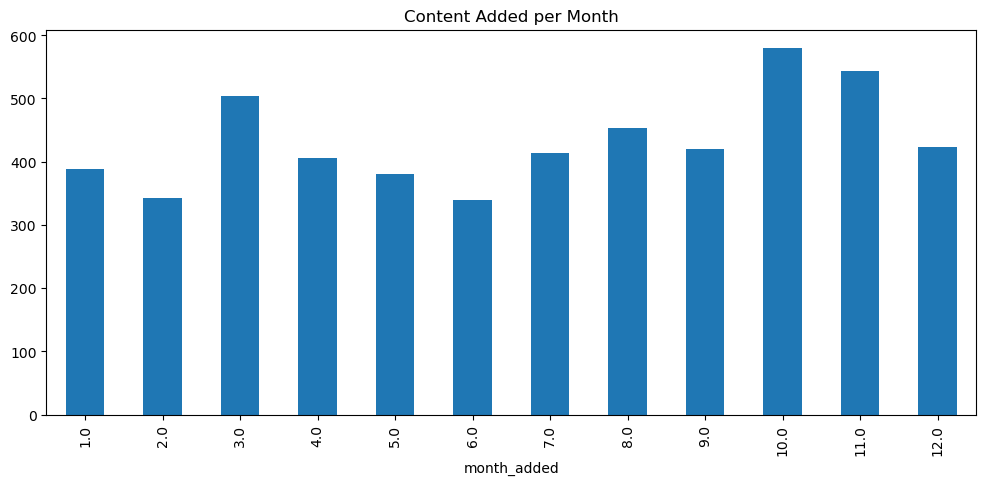

In [11]:
month_count = df.groupby('month_added').size()
month_count.plot(kind='bar', figsize=(12,5), title='Content Added per Month')
plt.show()

**Observation:**
Netflix consistently adds the most content in October and November, likely to capture holiday-season viewership. Content drops are seen in February and June, hinting at production or scheduling cycles.

## Category-Based Analysis

### Genre-Country Heatmap

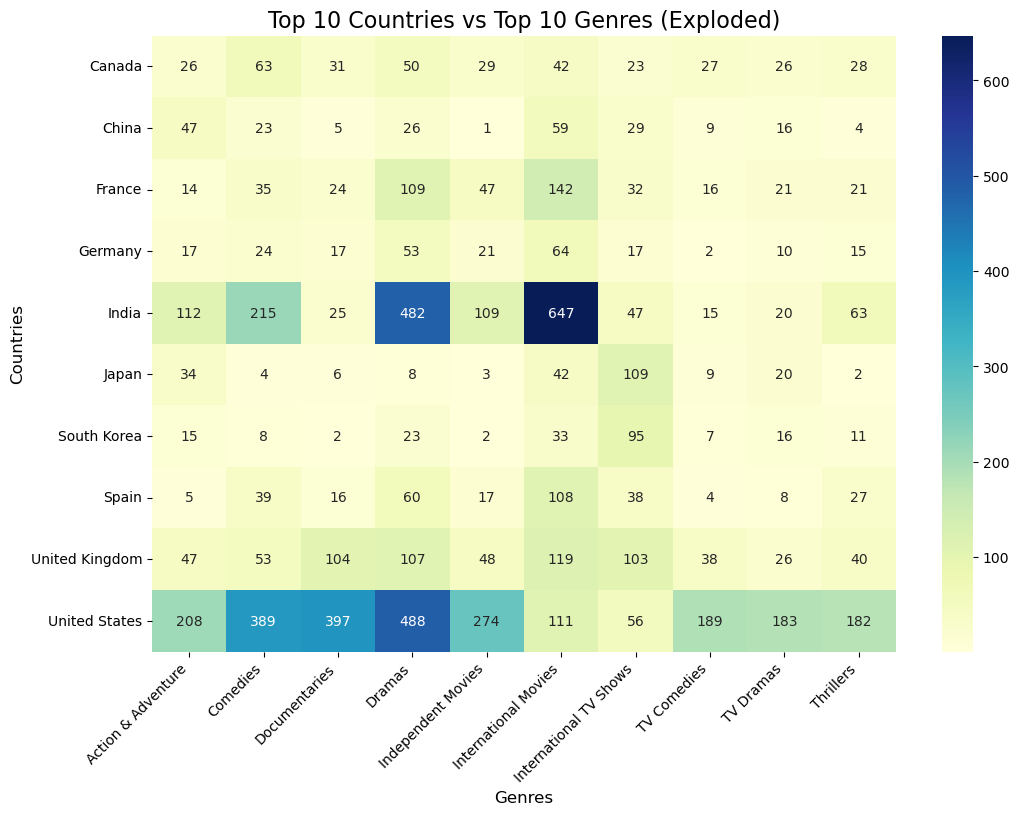

In [12]:
# Split and explode countries
df['country'] = df['country'].str.split(',')
df = df.explode('country')
df['country'] = df['country'].str.strip()

# Split and explode genres
df['listed_in'] = df['listed_in'].str.split(',')
df = df.explode('listed_in')
df['listed_in'] = df['listed_in'].str.strip()

# Get top 10 countries & genres
top_countries = df[df['country'] != 'Unknown']['country'].value_counts().head(10).index
top_genres = df['listed_in'].value_counts().head(10).index

# Pivot table
genre_country = pd.pivot_table(
    df[df['country'].isin(top_countries) & df['listed_in'].isin(top_genres)],
    index='country',
    columns='listed_in',
    aggfunc='size',
    fill_value=0
)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(genre_country, cmap='YlGnBu', annot=True, fmt="d")
plt.title('Top 10 Countries vs Top 10 Genres (Exploded)', fontsize=16)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Countries', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**Observation:**

India: Dominates International Movies and Dramas, reflecting its focus on regional storytelling.

United States: Strong presence across almost all genres, with peaks in Documentaries and Independent Movies.

Japan & South Korea: High concentration in TV Dramas, driven by anime and K-drama content.

France, Germany, UK: Show a more balanced genre distribution, contributing evenly across multiple categories.

## Actor-Genre Analysis

Top actors:
 Index(['David Attenborough', 'Anupam Kher', 'Shah Rukh Khan', 'Akshay Kumar',
       'Om Puri', 'Paresh Rawal', 'Yuki Kaji', 'Boman Irani',
       'Naseeruddin Shah', 'Takahiro Sakurai'],
      dtype='object', name='cast')
Pivot shape: (10, 29)


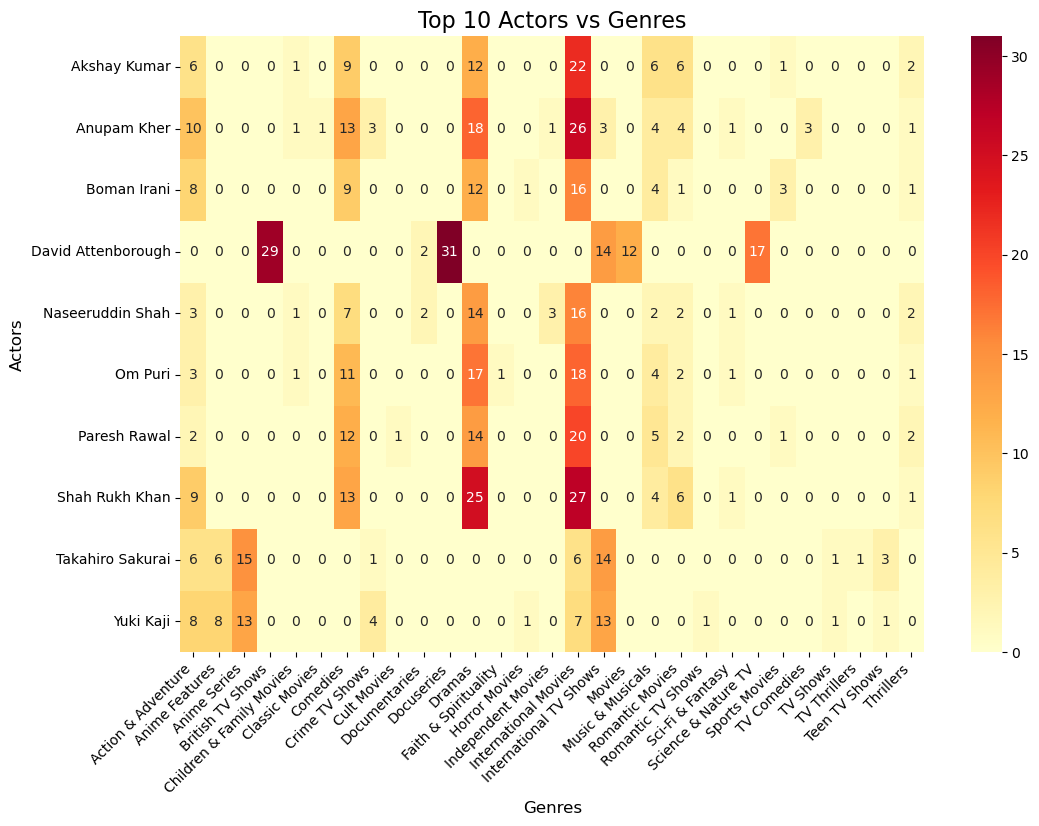

In [13]:
# Split into lists
df['cast'] = df['cast'].fillna("").astype(str).str.split(',')
df['listed_in'] = df['listed_in'].fillna("").astype(str).str.split(',')

# Explode
df_exploded = df.explode('cast').explode('listed_in')

# Strip whitespace
df_exploded['cast'] = df_exploded['cast'].str.strip()
df_exploded['listed_in'] = df_exploded['listed_in'].str.strip()

# Clean actor names
df_exploded['cast'] = (
    df_exploded['cast']
    .str.replace(r"[\[\]']", "", regex=True)  # remove brackets & quotes
    .str.strip()
)

# Remove Unknown + blanks for both cast and genre
df_filtered = df_exploded[
    (df_exploded['cast'] != "") &
    (df_exploded['cast'].str.lower() != "unknown") &
    (df_exploded['listed_in'] != "") &
    (df_exploded['listed_in'].str.lower() != "unknown")
]

# Get top 10 actors
top_actors = df_filtered['cast'].value_counts().head(10).index
print("Top actors:\n", top_actors)

# Pivot
actor_genre_pivot = pd.pivot_table(
    df_filtered[df_filtered['cast'].isin(top_actors)],
    index='cast',
    columns='listed_in',
    aggfunc='size',
    fill_value=0
)
print("Pivot shape:", actor_genre_pivot.shape)

# Heatmap
if not actor_genre_pivot.empty:
    plt.figure(figsize=(12,8))
    sns.heatmap(actor_genre_pivot, cmap="YlOrRd", annot=True, fmt="d")
    plt.title("Top 10 Actors vs Genres", fontsize=16)
    plt.xlabel("Genres", fontsize=12)
    plt.ylabel("Actors", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()
else:
    print("⚠️ Pivot table is empty – no data to plot.")

**Observation:**

The heatmap shows clear actor–genre trends.

- David Attenborough appears almost exclusively in Docuseries and British TV Shows.
- Shah Rukh Khan is prominent in International Movies and Dramas.
- Bollywood actors like Anupam Kher, Om Puri, and Paresh Rawal appear across multiple genres, reflecting versatility.
- Anime voice actors (Takahiro Sakurai, Yuki Kaji) are concentrated in Anime titles, showing niche specialization.

Overall, the chart highlights a balance of genre versatility (Bollywood stars) and niche dominance (anime voice actors).

## Raiting vs Top 10 Country Analysis

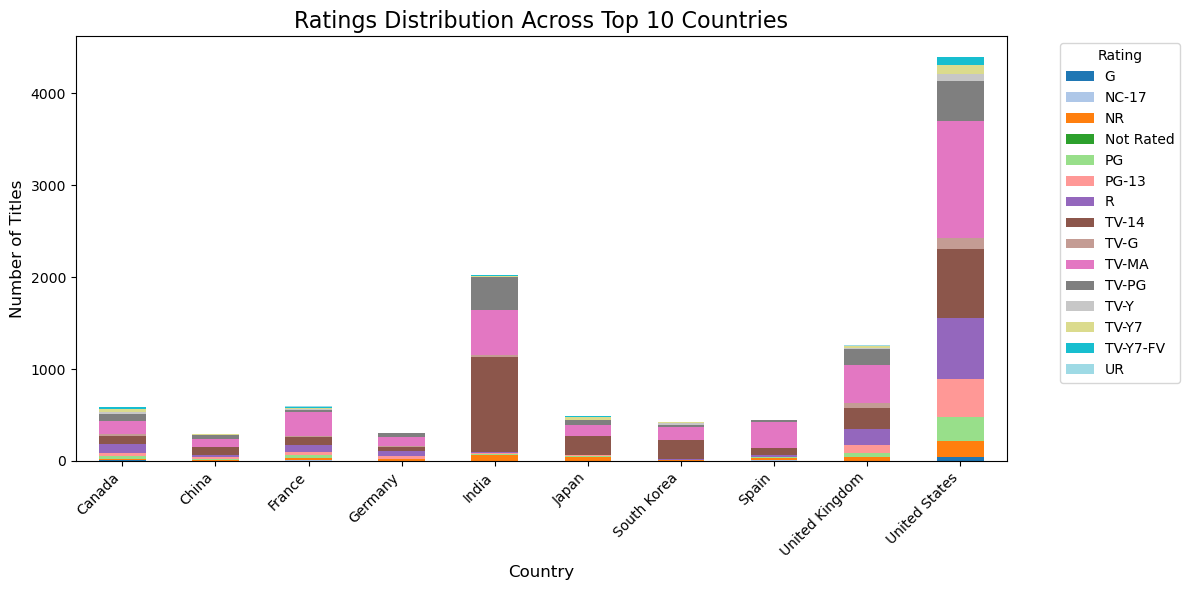

In [14]:
# Top 10 countries
top_countries = df[df['country'] != 'Unknown']['country'].value_counts().head(10).index

# Filter dataset
df_country_rating = df[df['country'].isin(top_countries)]

# Count of Raitings per country
country_rating = df_country_rating.groupby(['country', 'rating']).size().unstack(fill_value=0)

# Plot stacked bar chart
country_rating.plot(kind='bar', stacked=True, figsize=(12,6), colormap="tab20")
plt.title("Ratings Distribution Across Top 10 Countries", fontsize=16)
plt.xlabel("Country", fontsize=12)
plt.ylabel("Number of Titles", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Observation:**

The United States leads in content across nearly all ratings, with a strong focus on TV-MA and TV-14, reflecting its large and diverse production base.
India shows a heavy concentration in TV-14, highlighting its focus on family- and youth-friendly content.
Japan and South Korea also lean toward TV-14, consistent with their strong TV show industries.
European countries (France, Germany, Spain, UK) display a balanced spread across TV-MA, TV-14, and R, suggesting a mix of mature and general audience programming.

## Deep Dives

### TV Shows with Most Seasons

title
NCIS                                  15
Grey's Anatomy                        15
Supernatural                          14
Red vs. Blue                          13
COMEDIANS of the world                13
Trailer Park Boys                     12
Criminal Minds                        12
Frasier                               11
Heartland                             11
Cheers                                11
Friends                               10
Danger Mouse: Classic Collection      10
Dad's Army                            10
Club Friday The Series 6               9
Naruto                                 9
Shameless (U.S.)                       9
LEGO Ninjago: Masters of Spinjitzu     9
The Office (U.S.)                      9
Forensic Files                         9
The Walking Dead                       9
Name: seasons, dtype: int32


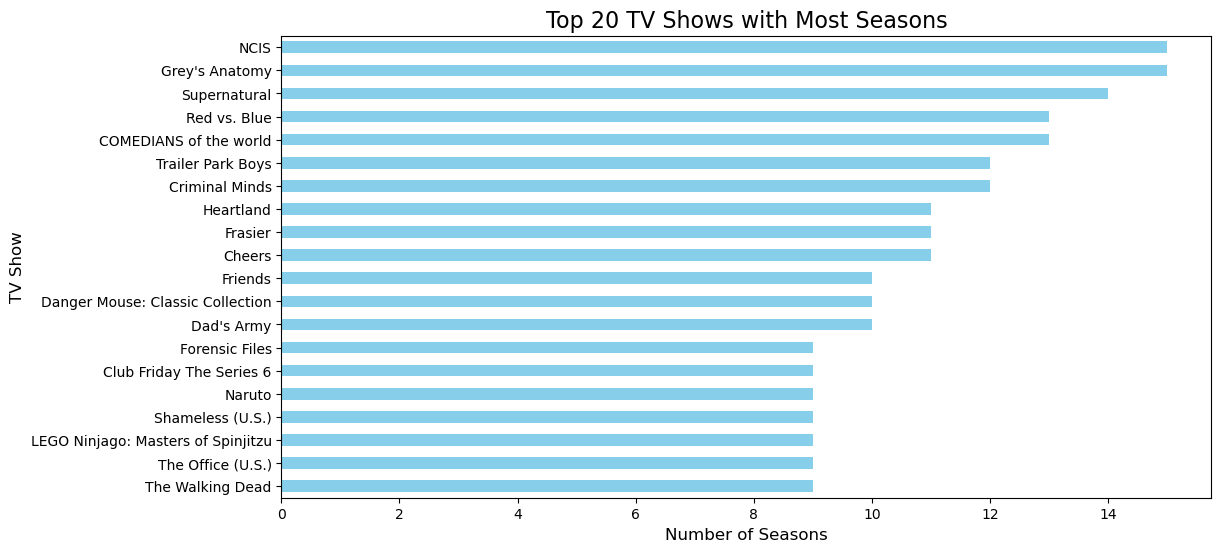

In [15]:
# Convert "9 Seasons" → 9, "1 Season" → 1
tv_df = df[df['type']=='TV Show'].copy()
tv_df['seasons'] = tv_df['duration'].str.extract(r'(\d+)').astype(int)

# Top 20 by season count
top_seasons = tv_df.groupby('title')['seasons'].max().sort_values(ascending=False).head(20)
print(top_seasons)

# Plot
plt.figure(figsize=(12,6))
top_seasons.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 20 TV Shows with Most Seasons", fontsize=16)
plt.xlabel("Number of Seasons", fontsize=12)
plt.ylabel("TV Show", fontsize=12)
plt.show()

**Observation:**

The chart highlights Netflix’s longest-running shows, led by NCIS and Grey’s Anatomy with 15+ seasons, followed by Supernatural (15 seasons).
Popular sitcoms like Friends, Frasier, and The Office (U.S.) also appear with ~9–10 seasons.
The list features a mix of U.S. dramas, sitcoms, anime (Naruto), and animated series (LEGO Ninjago, Danger Mouse), reflecting Netflix’s diverse catalog and global audience appeal.

### Movie Duration vs Ratings

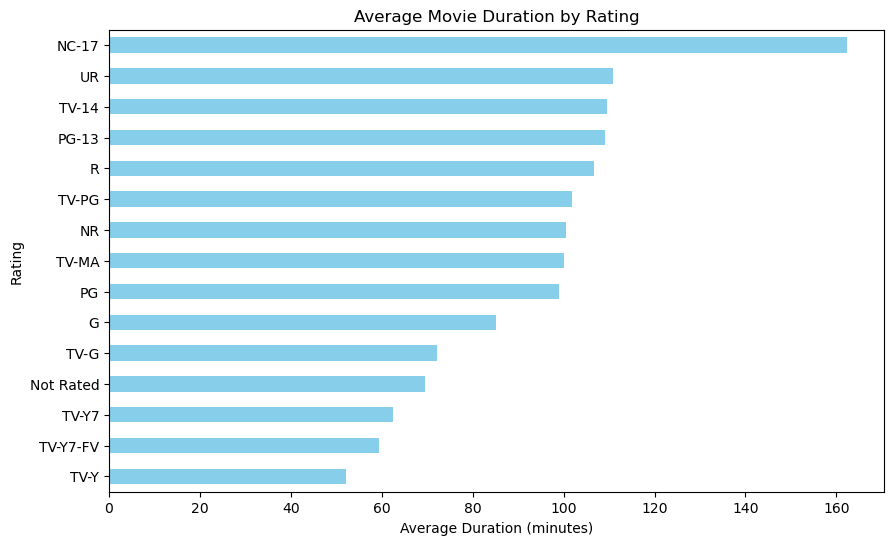

In [16]:
# Extract numeric duration for movies
df['duration_num'] = df['duration'].str.replace(' min','')
df['duration_num'] = pd.to_numeric(df['duration_num'], errors='coerce')

avg_duration = df[df['type']=='Movie'].groupby('rating')['duration_num'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_duration.plot(kind='barh', color='skyblue')
plt.title("Average Movie Duration by Rating")
plt.xlabel("Average Duration (minutes)")
plt.ylabel("Rating")
plt.show()

**Observation:**

Movies with NC-17 ratings have the longest average duration (approximately 160 min), followed by Unrated and PG-13/TV-14 titles (approximately 110 min).
Kids’ content (TV-Y, TV-Y7, TV-G) is significantly shorter (approximately 50–70 min), reflecting its focus on concise storytelling for younger audiences.